German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 3 : Tracking, visualizing and save models

Our main steps:
 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery pont

## 1/ Import and init

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import os, time, random

import idle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.4
  Run time           : Wednesday 15 January 2020, 11:19:11
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
%%time

def read_dataset(name):
    '''Reads h5 dataset from ./data

    Arguments:  dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename='./data/'+name+'.h5'
    with  h5py.File(filename) as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test,x_meta,y_meta

x_train,y_train,x_test,y_test,x_meta,y_meta = read_dataset('set-24x24-L')

Dataset "set-24x24-L" is loaded. (228.8 Mo)

CPU times: user 20 ms, sys: 296 ms, total: 316 ms
Wall time: 2.07 s


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


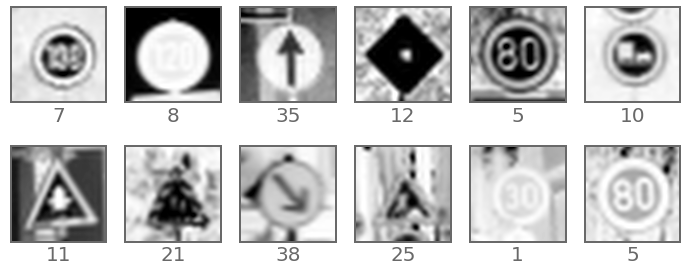

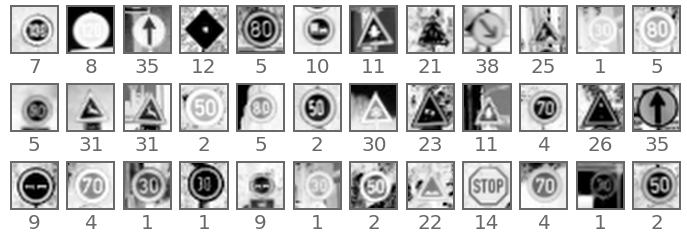

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

ooo.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2)
ooo.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model
We will now build a model and train it...

Some models... 

In [4]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## 5/ Prepare callbacks  
We will add 2 callbacks :  
 - **TensorBoard**  
Training logs, which can be visualised with Tensorboard.  
`#tensorboard --logdir ./run/logs`  
IMPORTANT : Relancer tensorboard à chaque run
 - **Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [5]:
%%bash
# To clean old logs and saved model, run this cell
#
/bin/rm -r ./run/logs 2>/dev/null
/bin/rm -r ./run/models 2>/dev/null
/bin/ls -l ./run  2>/dev/null

total 0


In [6]:
ooo.mkdir('./run/models')
ooo.mkdir('./run/logs')

# ---- Callback tensorboard
log_dir = "./run/logs/tb_" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./run/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./run/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_freq=2000*5)

## 5/ Train the model
**Get the shape of my data :**

In [7]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [8]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note : La courbe d'apprentissage est visible en temps réel avec Tensorboard :    
`#tensorboard --logdir ./run/logs`  

In [9]:
%%time

batch_size = 64
epochs     = 30

# ---- Shuffle train data
x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train[:5000], y_train[:5000],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test[:200], y_test[:200]),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./run/models/last-model.h5')

Train on 5000 samples, validate on 200 samples
Epoch 1/30
5000/5000 [==============================] - 3s 669us/sample - loss: 3.3748 - accuracy: 0.1088 - val_loss: 2.9594 - val_accuracy: 0.2850
Epoch 2/30
5000/5000 [==============================] - 2s 490us/sample - loss: 2.0842 - accuracy: 0.4414 - val_loss: 1.5636 - val_accuracy: 0.5550
Epoch 3/30
5000/5000 [==============================] - 2s 470us/sample - loss: 1.1964 - accuracy: 0.6546 - val_loss: 1.1344 - val_accuracy: 0.6700
Epoch 4/30
5000/5000 [==============================] - 3s 515us/sample - loss: 0.8034 - accuracy: 0.7570 - val_loss: 0.9471 - val_accuracy: 0.7450
Epoch 5/30
5000/5000 [==============================] - 2s 471us/sample - loss: 0.5804 - accuracy: 0.8266 - val_loss: 0.7523 - val_accuracy: 0.8000
Epoch 6/30
5000/5000 [==============================] - 2s 495us/sample - loss: 0.4359 - accuracy: 0.8646 - val_loss: 0.6976 - val_accuracy: 0.8050
Epoch 7/30
5000/5000 [==============================] - 2s 460us/

**Evaluate it :**

In [10]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9000


In [11]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4549
Test accuracy  : 0.9183


## 6/ History
The return of model.fit() returns us the learning history

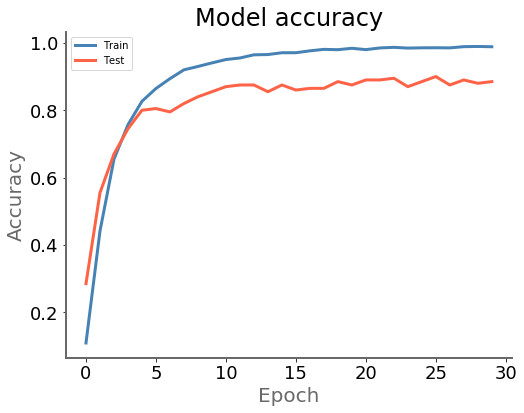

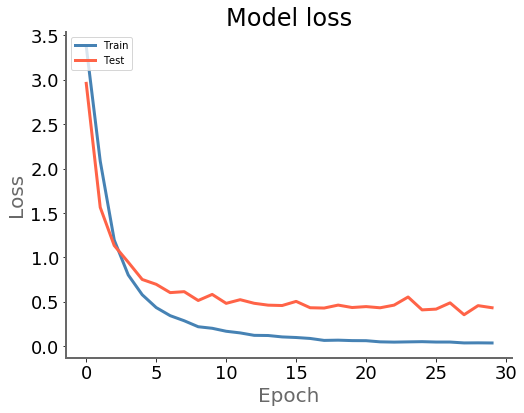

In [12]:
ooo.plot_history(history)

## 7/ Evaluation and confusion

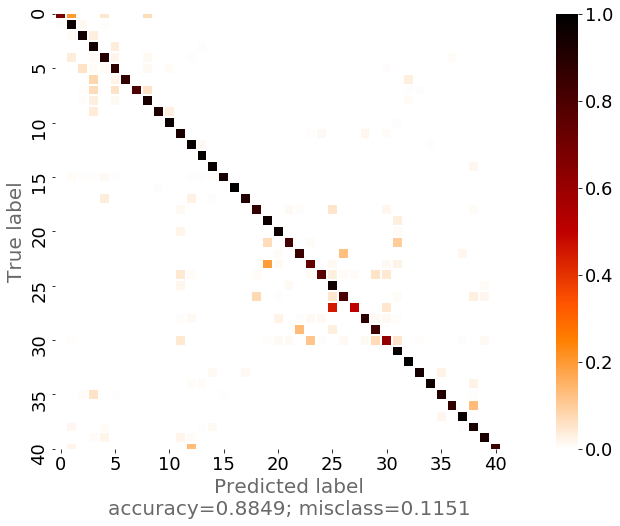

In [13]:
y_pred   = model.predict_classes(x_test)
conf_mat = confusion_matrix(y_test,y_pred, normalize="true", labels=range(43))

ooo.plot_confusion_matrix(conf_mat)

## 8/ Restore and evaluate
### 8.1/ List saved models :

In [14]:
!find ./run/models/

./run/models/
./run/models/best-model.h5
./run/models/model-0002.h5
./run/models/model-0004.h5
./run/models/model-0006.h5
./run/models/model-0008.h5
./run/models/model-0010.h5
./run/models/model-0012.h5
./run/models/model-0014.h5
./run/models/model-0016.h5
./run/models/model-0018.h5
./run/models/model-0020.h5
./run/models/model-0022.h5
./run/models/model-0024.h5
./run/models/model-0026.h5
./run/models/model-0028.h5
./run/models/model-0030.h5
./run/models/last-model.h5


### 8.2/ Restore a model :

In [3]:
loaded_model = tf.keras.models.load_model('./run/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.3/ Evaluate it :

In [5]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.5084
Test accuracy  : 0.9177


### 8.4/ Make a prediction :


Output layer from model is (x100) :

[[ 0.    0.01  0.07  1.31  0.01  0.    0.    0.    0.    1.47  0.02  0.    0.01  0.17 37.19
   0.75  0.    0.23  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.05  0.05  0.7   0.55  0.05  0.   57.34  0.    0.    0.    0.  ]]

Graphically :



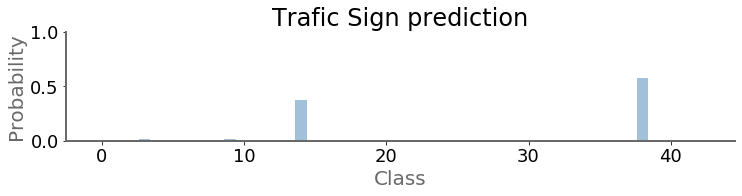


Prediction on the left, real stuff on the right :



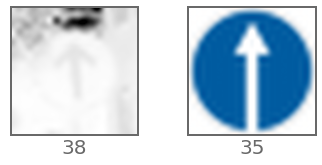

oups, that's wrong ;-(


In [7]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nPrediction on the left, real stuff on the right :\n")
ooo.plot_images([x,x_meta[y]], [p,y], range(2),  columns=3,  x_size=3, y_size=2)

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

---
That's all folks !